Nodes: ['circuits', 'constructorResults', 'races', 'constructors', 'constructorStandings', 'driverStandings', 'drivers', 'lapTimes', 'pitStops', 'qualifying', 'seasons', 'results', 'status']
Edges: [('circuits', 'races'), ('constructorResults', 'races'), ('constructorResults', 'constructors'), ('races', 'constructorResults'), ('races', 'constructorStandings'), ('races', 'driverStandings'), ('races', 'lapTimes'), ('races', 'pitStops'), ('races', 'qualifying'), ('races', 'seasons'), ('races', 'circuits'), ('races', 'results'), ('constructors', 'constructorResults'), ('constructors', 'constructorStandings'), ('constructors', 'qualifying'), ('constructors', 'results'), ('constructorStandings', 'races'), ('constructorStandings', 'constructors'), ('driverStandings', 'races'), ('driverStandings', 'drivers'), ('drivers', 'driverStandings'), ('drivers', 'lapTimes'), ('drivers', 'pitStops'), ('drivers', 'qualifying'), ('drivers', 'results'), ('lapTimes', 'races'), ('lapTimes', 'drivers'), ('pitS

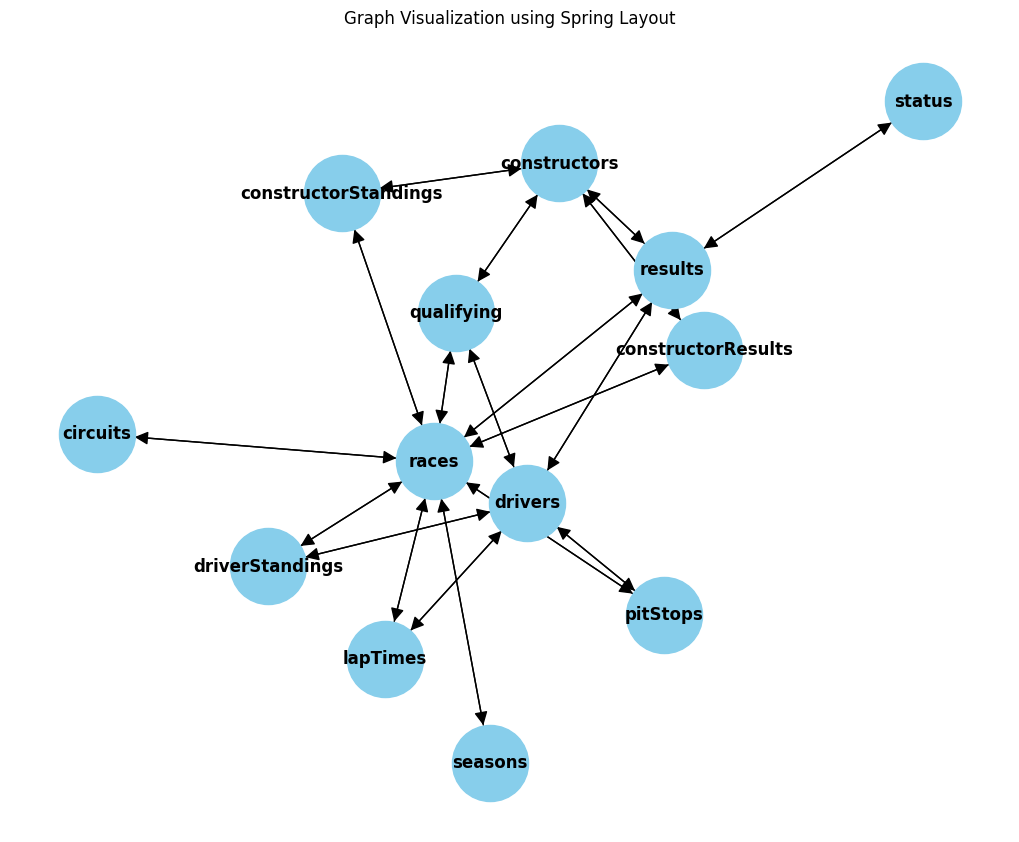

In [9]:
import networkx as nx
import sqlalchemy
import tool


def one_hop_query(graph, table_name):
    if table_name in graph:
        neighbors = list(graph.neighbors(table_name))
        neighbors.insert(0, table_name)  # 将本身插入到结果的最前面
        return neighbors
    else:
        return [table_name] if table_name in graph else []


# 2跳查询：查询某个表的所有邻居的邻居，并保留本身和邻居
def two_hop_query(graph, table_name):
    if table_name in graph:
        neighbors = list(graph.neighbors(table_name))
        two_hop_neighbors = set(neighbors)
        for neighbor in neighbors:
            two_hop_neighbors.update(graph.neighbors(neighbor))
        # 移除直接邻居和自身
        two_hop_neighbors.discard(table_name)
        # 将本身和直接邻居插入到结果的最前面
        result = [table_name] + neighbors + list(two_hop_neighbors)
        return result
    else:
        return [table_name] if table_name in graph else []


engine = tool.get_engine(
    {
        "type": "sqlite",
        "url": "/home/data2/luzhan/projects/bird_bench/dev/dev_databases/formula_1/formula_1.sqlite",
    }
)


def build_graph(engine):
    inspector = sqlalchemy.inspect(engine)
    table_names = inspector.get_table_names()
    G = nx.DiGraph()
    for table_name in table_names:
        G.add_node(table_name)
        foreign_keys = inspector.get_foreign_keys(table_name)
        for foreign_key in foreign_keys:
            ref_table = foreign_key["referred_table"]
            G.add_edge(table_name, ref_table)
            G.add_edge(ref_table, table_name)
    return G


G = build_graph(engine)
print("Nodes:", G.nodes())
print("Edges:", G.edges())
print(len(one_hop_query(G, "drivers")))
print(len(two_hop_query(G, "drivers")))
# 可选：绘制图
# 使用spring_layout布局
pos = nx.spring_layout(G, seed=42)  # seed参数用于固定布局，便于调试
import matplotlib.pyplot as plt

# 绘制图
plt.figure(figsize=(10, 8))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=3000,
    node_color="skyblue",
    font_size=12,
    font_weight="bold",
    arrowstyle="-|>",
    arrowsize=20,
)
plt.title("Graph Visualization using Spring Layout")
plt.show()